In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
import optuna
import kagglehub

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import (
    mean_absolute_error,
    classification_report
)
from features_all import *
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
kagglehub.dataset_download(
    "nemasterr/sneaker-sales-on-the-marketplace",
    output_dir="data"
)

100%|██████████| 1.06M/1.06M [00:00<00:00, 1.53MB/s]

Extracting files...


'data2'

In [2]:
df = pd.read_parquet('data/train.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309648 entries, 0 to 309647
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nm_id           309648 non-null  object        
 1   dt              309648 non-null  datetime64[ns]
 2   qty             309648 non-null  int64         
 3   price           309648 non-null  int64         
 4   is_promo        309648 non-null  int64         
 5   prev_leftovers  309648 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 14.2+ MB


Files `train.parquet` and `test.parquet` contain:
 
- **nm_id** — anonymous product identifier  
- **dt** — date  
- **price** — product price on that day  
- **is_promo** — flag indicating product participation in promotion  
- **prev_leftovers** — product inventory at the beginning of the day  
- **qty** — number of units sold, present only in `train` (target feature)

**Period start:** 2024-07-04  
**Period end:** 2025-07-07

Sales statistics:
    Mean: 0.8459056735389862
    Median: 0.0
    Mode: 0
    Variance: 23.895656969245444
    Standard deviation: 4.888318419379556
    


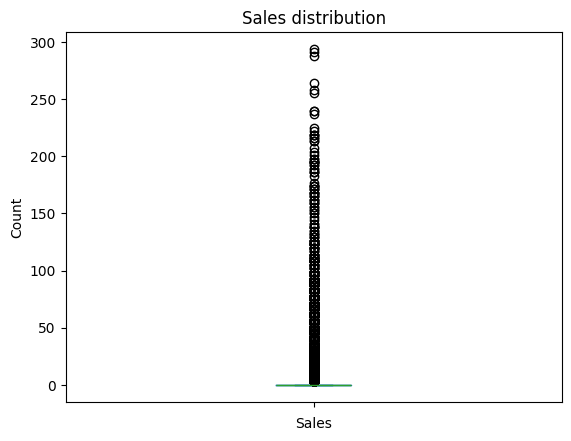

In [4]:
qty = df['qty']

print(
    f"""Sales statistics:
    Mean: {qty.mean()}
    Median: {qty.median()}
    Mode: {qty.mode()[0]}
    Variance: {qty.var(ddof=0)}
    Standard deviation: {qty.std(ddof=0)}
    """
)

df[['qty']].plot.box()
plt.title('Sales distribution')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.xticks([1], ['']) 
plt.style.use('ggplot')      
plt.show()

In [32]:
df.head()

,nm_id,dt,qty,price,is_promo,prev_leftovers
0,015ecac1-0d4d-4272-9f9c-7c62a742a679,2024-07-04,0,2940,0,54
1,02790618-93a6-4a2e-92e2-72cbb0bf24cf,2024-07-04,3,6543,0,75
2,03cf7d0c-4709-409d-a964-44558ada7e3d,2024-07-04,3,4983,0,66
3,0407f293-33e5-4c34-8236-9ddef5a166f0,2024-07-04,3,1971,1,132
4,046336e9-58cd-4d0f-b521-c70607fd9ec4,2024-07-04,0,2133,1,87


In [ ]:
# 1. Features that do NOT depend on qty — compute on the whole df
df = add_temporal_features(df)
df = add_price_features(df)
df = add_promo_features(df)
df = add_leftovers_features(df)
df = add_interaction_features(df)

# 2. Split
threshold_time = df["dt"].quantile(0.9)
train_mask = df["dt"] <= threshold_time

# 3. Features that depend on qty — compute only on train
train_df = df[train_mask].copy()
train_df = add_sales_lag_features(train_df)
train_df = add_item_features(train_df)          
train_df = add_elasticity_features(train_df)

test_df = df[~train_mask].copy()

# item_features without qty (lifetime, mean_price, price_std — will be calculated)
test_df = add_item_features(test_df)

# Lags for test: take the tail of train and the head of test, compute, keep only test
border_df = pd.concat([
    df[train_mask].tail(28 * df["nm_id"].nunique()),  # last 28 days of train
    test_df
]).sort_values(["nm_id", "dt"])
border_df = add_sales_lag_features(border_df)

# Take back only the test rows
test_df = border_df[border_df["dt"] > threshold_time].copy()

# 5. Build X, y
drop_cols = ["qty"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["qty"]
X_test = test_df.drop(columns=drop_cols, errors="ignore")
y_test = df.loc[~train_mask, "qty"]

/Users/vladpalamarchuk/Documents/coding/hse-hackathon/features_all.py:231: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: rolling_corr(g, window))


In [ ]:
# Bring columns to a common set
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

In [ ]:
# MAE weights
weights_train = np.where(y_train > 0, 7.0, 1.0)
weights_test = np.where(y_test > 0, 7.0, 1.0)

In [39]:
train_pool = Pool(X_train, y_train, weight=weights_train, cat_features=["is_promo", "nm_id"])
eval_pool = Pool(X_test, y_test, weight=weights_test, cat_features=["is_promo", "nm_id"])

with mlflow.start_run():
    model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.03,
        random_seed=42,
        loss_function="MAE"
    )

    model.fit(
        train_pool,
        eval_set=eval_pool,
        plot=True,
        early_stopping_rounds=50,
        use_best_model=True,
        verbose=30
    )

    mlflow.log_params(model.get_params())
    mlflow.log_param("feature_names", list(X_train.columns))
    mlflow.log_param("cat_features", ["is_promo", "nm_id"])
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    })
    mlflow.log_dict(feature_importance.to_dict(), "feature_importance.json")

    mlflow.log_metric("val_mae", model.best_score_["validation"]["MAE"])
    mlflow.catboost.log_model(model, artifact_path="model")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.1580240	test: 4.1470123	best: 4.1470123 (0)	total: 73.4ms	remaining: 21.9s
30:	learn: 2.7677140	test: 3.3838343	best: 3.3838343 (30)	total: 1.61s	remaining: 14s
60:	learn: 2.5488156	test: 2.9442775	best: 2.9442775 (60)	total: 2.99s	remaining: 11.7s
90:	learn: 2.4325739	test: 2.7492170	best: 2.7492170 (90)	total: 4.19s	remaining: 9.63s
120:	learn: 2.3698086	test: 2.6720957	best: 2.6720957 (120)	total: 5.31s	remaining: 7.86s
150:	learn: 2.3289673	test: 2.6311521	best: 2.6311521 (150)	total: 6.34s	remaining: 6.25s
180:	learn: 2.2854519	test: 2.5978237	best: 2.5978237 (180)	total: 7.3s	remaining: 4.8s
210:	learn: 2.2543993	test: 2.5754430	best: 2.5754430 (210)	total: 8.25s	remaining: 3.48s
240:	learn: 2.2355868	test: 2.5744689	best: 2.5741116 (234)	total: 9.19s	remaining: 2.25s
270:	learn: 2.2249975	test: 2.5725346	best: 2.5719063 (252)	total: 10.1s	remaining: 1.08s
299:	learn: 2.2091920	test: 2.5715667	best: 2.5695952 (281)	total: 11s	remaining: 0us

bestTest = 2.569595244
bes

2026/02/16 23:31:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run thoughtful-stoat-557 at: http://localhost:5050/#/experiments/1/runs/61bb5101fda548948fb60fbc22393248
🧪 View experiment at: http://localhost:5050/#/experiments/1


In [ ]:

train_pool = Pool(X_train, y_train, weight=weights_train, cat_features=["is_promo", "nm_id"])
eval_pool = Pool(X_test, y_test, weight=weights_test, cat_features=["is_promo", "nm_id"])


# --- 1. Optuna: hyperparameter tuning ---

def objective(trial):
    params = {
        "iterations": 3000,
        "learning_rate": trial.suggest_float("lr", 0.005, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 2.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "loss_function": "MAE",
        "random_seed": 42,
        "verbose": 0,
    }

    # Each trial is a nested run in MLflow
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        model = CatBoostRegressor(**params)
        model.fit(
            train_pool,
            eval_set=eval_pool,
            early_stopping_rounds=50,
            use_best_model=True,
        )

        mae = model.best_score_["validation"]["MAE"]

        mlflow.log_params(trial.params)
        mlflow.log_metric("val_mae", mae)
        mlflow.log_metric("best_iteration", model.best_iteration_)

    return mae


# --- 2. Launch: parent run wraps all trials ---

with mlflow.start_run(run_name="optuna_search"):

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Log the best parameters
    mlflow.log_params({f"best_{k}": v for k, v in study.best_params.items()})
    mlflow.log_metric("best_val_mae", study.best_value)

    # --- 3. Final model with best parameters ---

    best = study.best_params
    final_model = CatBoostRegressor(
        iterations=3000,
        learning_rate=best["lr"],
        depth=best["depth"],
        l2_leaf_reg=best["l2_leaf_reg"],
        min_data_in_leaf=best["min_data_in_leaf"],
        bagging_temperature=best["bagging_temperature"],
        random_strength=best["random_strength"],
        loss_function="MAE",
        random_seed=42,
        verbose=50,
    )
    final_model.fit(
        train_pool,
        eval_set=eval_pool,
        early_stopping_rounds=100,
        use_best_model=True,
    )

    final_mae = final_model.best_score_["validation"]["MAE"]
    mlflow.log_metric("final_val_mae", final_mae)
    mlflow.log_param("final_best_iteration", final_model.best_iteration_)
    mlflow.log_param("feature_names", list(X_train.columns))
    mlflow.log_param("cat_features", ["is_promo", "nm_id"])

    feature_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": final_model.feature_importances_,
    }).sort_values("importance", ascending=False)
    mlflow.log_dict(feature_importance.to_dict(), "feature_importance.json")

    mlflow.catboost.log_model(final_model, name="model")

In [ ]:
# Prediction on test set
train_raw = pd.read_parquet("data/train.parquet")
test_raw = pd.read_parquet("data/test.parquet")

train_raw["dt"] = pd.to_datetime(train_raw["dt"])
test_raw["dt"] = pd.to_datetime(test_raw["dt"])

# Label for merging back later
train_raw["_is_train"] = True
test_raw["_is_train"] = False

full = pd.concat([train_raw, test_raw], ignore_index=True)
full = full.sort_values(["nm_id", "dt"]).reset_index(drop=True)

# ── 2. Features without qty — use the whole dataframe ──
full = add_temporal_features(full)
full = add_price_features(full)
full = add_promo_features(full)
full = add_leftovers_features(full)
full = add_interaction_features(full)

# ── 3. Features involving qty — mask qty in test before calculation ──
# Set qty to NaN in test rows so lags do not peek into the future
full["qty_safe"] = full["qty"].where(full["_is_train"], other=np.nan)

# Manual lags — via qty_safe
g = full.groupby("nm_id")["qty_safe"]

for lag in [1, 7, 14, 28]:
    full[f"qty_lag_{lag}d"] = g.shift(lag)

full["qty_same_dow_lag"] = g.shift(7)

for w in [7, 14, 30]:
    full[f"qty_rmean_{w}d"] = g.transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).mean()
    )
    full[f"qty_rstd_{w}d"] = g.transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).std()
    )

full["qty_expanding_mean"] = g.transform(
    lambda x: x.shift(1).expanding().mean()
)

# item_mean_qty — expanding mean of known sales
full["item_mean_qty"] = g.transform(
    lambda x: x.shift(1).expanding().mean()
)

# Average price and volatility — do not depend on qty
full["item_mean_price"] = full.groupby("nm_id")["price"].transform(
    lambda x: x.expanding().mean()
)
full["item_price_std"] = full.groupby("nm_id")["price"].transform(
    lambda x: x.expanding().std()
)
full["item_lifetime_days"] = full.groupby("nm_id").cumcount() + 1

# Elasticity — rolling corr only on known qty
def safe_rolling_corr(group, w=30):
    return group["price"].rolling(w, min_periods=w // 2).corr(group["qty_safe"])

full["price_qty_corr_30d"] = (
    full.groupby("nm_id", group_keys=False)
        .apply(safe_rolling_corr, include_groups=False)
)

# Pseudo-elasticity
full["_price_pct"] = full.groupby("nm_id")["price"].pct_change()
full["_qty_pct"] = full.groupby("nm_id")["qty_safe"].pct_change()
full["pseudo_elasticity"] = (full["_qty_pct"] / full["_price_pct"].replace(0, np.nan)).clip(-10, 10)
full.drop(columns=["_price_pct", "_qty_pct", "qty_safe"], inplace=True)

# ── 4. Split back ──
train_df = full[full["_is_train"]].copy()
test_df = full[~full["_is_train"]].copy()

drop_cols = ["qty", "_is_train"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["qty"]
X_test = test_df.drop(columns=drop_cols, errors="ignore")

/var/folders/w5/njx7ldwn63j1v74_7qjmpfnc0000gn/T/ipykernel_52113/1653689745.py:71: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  full["_qty_pct"] = full.groupby("nm_id")["qty_safe"].pct_change()


In [ ]:
predictions = final_model.predict(X_test)

In [45]:
submission = test_raw[["nm_id", "dt"]].copy()
submission["qty"] = np.clip(np.round(predictions), 0, None).astype(int)
submission.to_csv("data/submission.csv", index=False)